In [1]:
import random
from collections import defaultdict, deque

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def bfs_scout(G, node, max_d):
    res = []  # radius: neighbors
    q = deque()
    q.append((node, 0))
    while len(q) > 0:
        cur_node, d_cur = q.popleft()
        if d_cur >= max_d:
            break
        for n in G.neighbors(cur_node):
            q.append((n, d_cur + 1))
            res.append(n)
    return res


In [3]:
# Parameters for the random graph
n = 50  # Number of nodes
p = 0.2  # Probability of edge creation

# Generate a random graph
G = nx.erdos_renyi_graph(n, p)

# Function to find a random path from source to target
def random_path(G, start, end):
    for path in nx.all_simple_paths(G, start, end):
        if random.random() < 0.3:
            return path


# Find a random path from node 0 to node n-1
path = random_path(G, 0, n-1)

In [4]:
def print_graph_with_path_and_subgraph(G, path=None, subgraph=None):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_size=16, font_weight='bold')
    if path is not None:
        path_edges = list(zip(path, path[1:]))
        subgraph = subgraph or []
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, style='dashed')
        nx.draw_networkx_nodes(G, pos, nodelist=path+list(subgraph), node_color='lightgreen', node_size=600)
    plt.title(f'Random Graph with Random Path from Node 0 to Node {n-1}')
    plt.show()

In [5]:
WINDOW = 3  # minimum window that makes sense

def find_window_subgraph(G, i, j, path):
    R = j - i - 2  # maximum distance that makes sence
    neighbors_i = list(G.neighbors(path[i]))
    neighbors_j_r = bfs_scout(G, path[j], R)
    return set(neighbors_i).intersection(set(neighbors_j_r))


def populate_subgraph(G, path, window_size):
    i = 0
    j = i + window_size

    NEIGHBOR_NODES = set()

    while j < len(path):
        NEIGHBOR_NODES = NEIGHBOR_NODES.union(find_window_subgraph(G, i, j, path))
        i += 1
        j += 1
    
    return NEIGHBOR_NODES


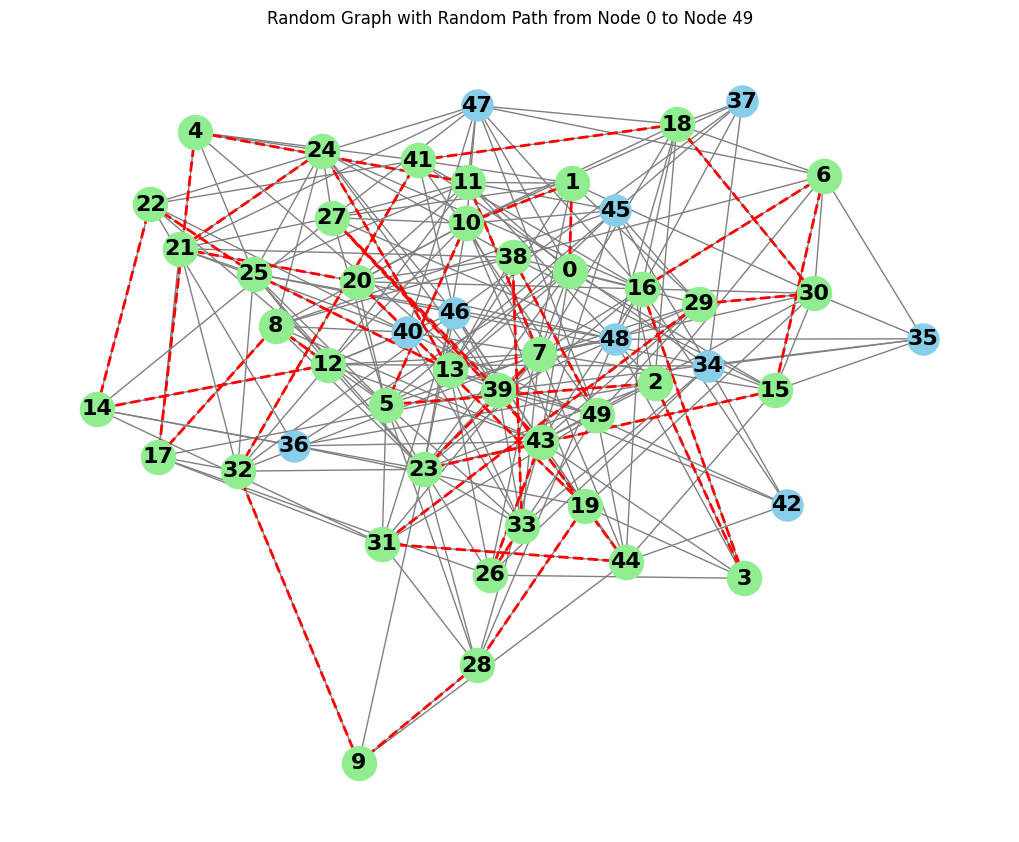

In [108]:
print_graph_with_path_and_subgraph(G, path)

In [109]:
subgraph = find_window_subgraph(G, 0, 4, path)
subgraph

{1, 7, 11, 13, 15, 16, 23, 36, 43, 47}

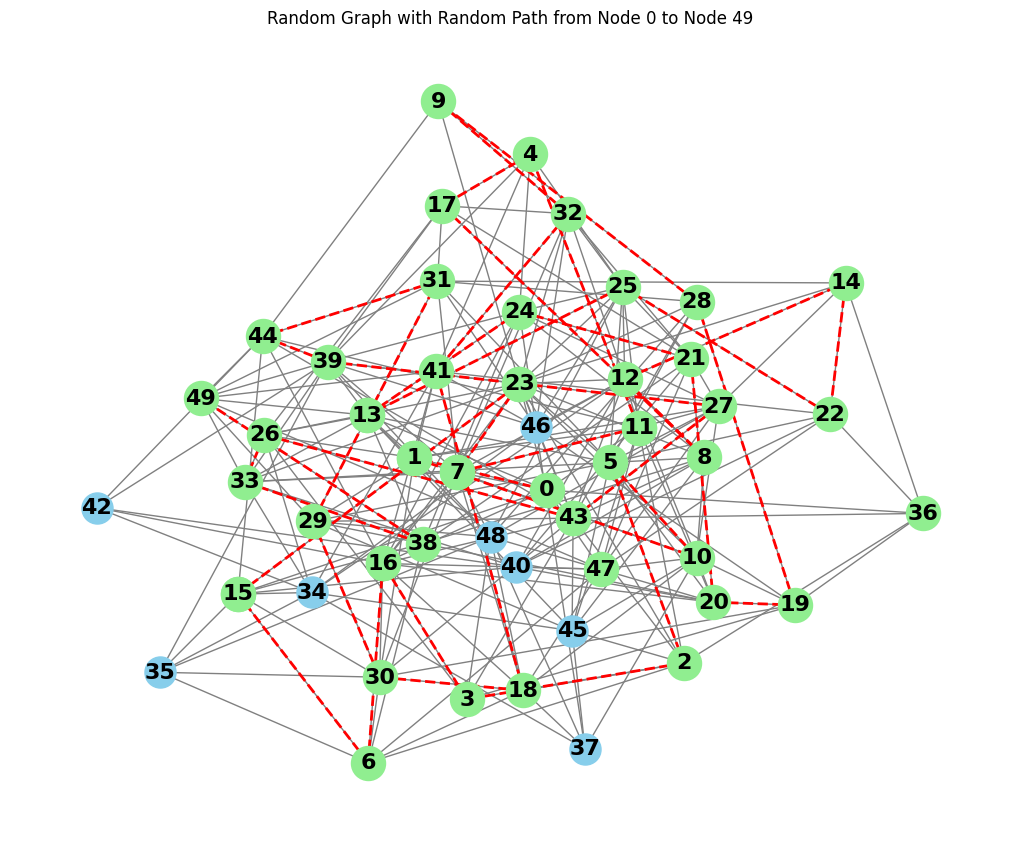

In [110]:
print_graph_with_path_and_subgraph(G, path, subgraph)

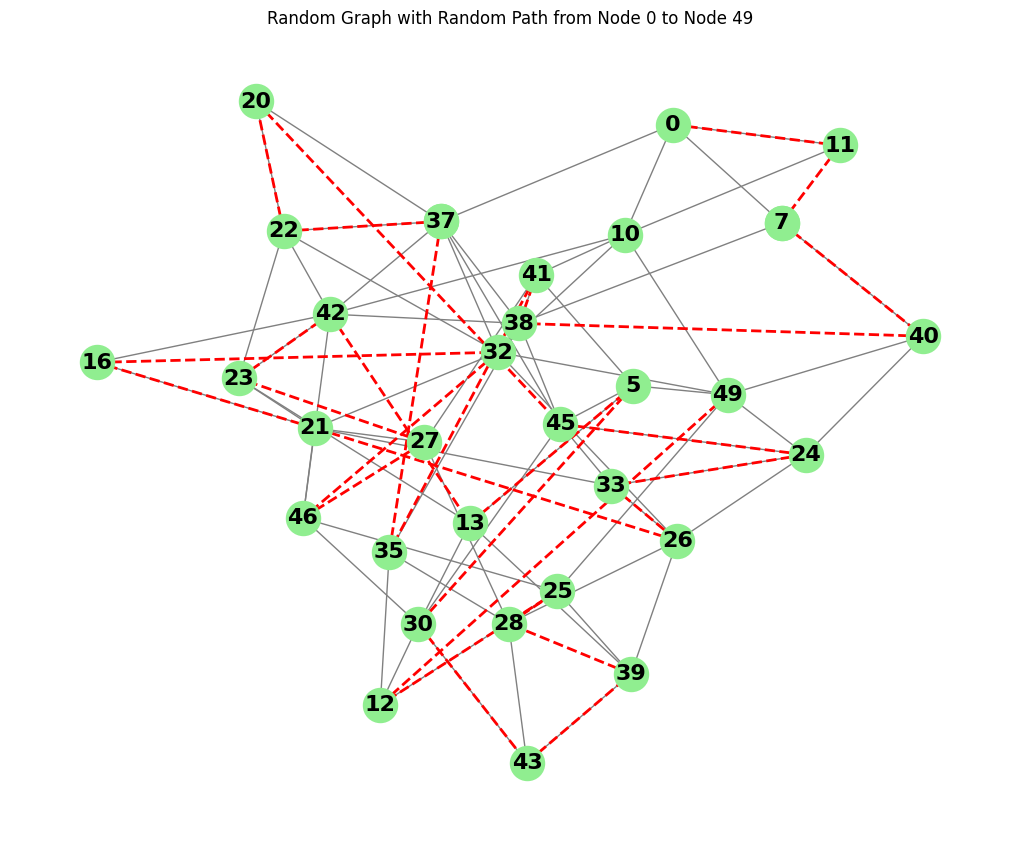

In [86]:
print_graph_with_path_and_subgraph(G.subgraph(path+subgraph), path, subgraph)

In [111]:
len(path)

40

In [113]:
new_path = nx.shortest_path(G.subgraph(path+list(subgraph)), source=path[0], target=path[-1])
new_path

[0, 13, 49]

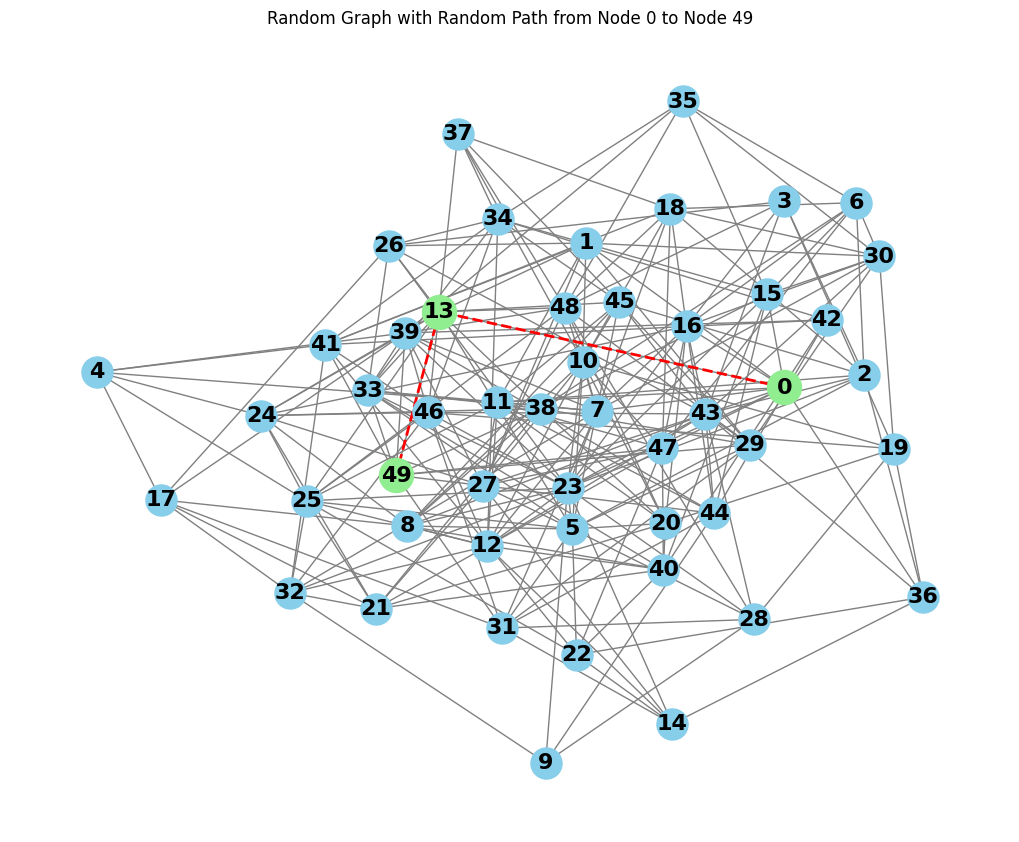

In [114]:
print_graph_with_path_and_subgraph(G, new_path)

In [6]:
ER_GRAPH_PROBABILITIES = [0.01, 0.1, 0.2]
NUM_NODES = [int(x) for x in [1e3, 1e4, 1e5, 1e6]]
WINDOW_SIZE = [3, 5, 7]

In [13]:
from multiprocessing import Pool


TEST_RESULTS = {}

def run_test(num_nodes, er_prob, window):
    G = nx.erdos_renyi_graph(num_nodes, er_prob)
    path = random_path(G, 0, num_nodes-1)
    new_len = len(path)
    i = 0
    while True:
        subgraph = populate_subgraph(G, path, window)
        new_path = nx.shortest_path(G.subgraph(path+list(subgraph)), source=path[0], target=path[-1])
        if len(new_path) >= new_len:
            break
        new_len = len(new_path)
        i += 1
    test_code = f'n{num_nodes}_prob{er_prob}_window{window}'
    print(f'{test_code}: {len(path)}->{len(new_path)}, number of iterations: {i}')
    return test_code, path, new_path, i

In [14]:
TESTBED = []
for num_nodes in NUM_NODES:
    for er_prob in ER_GRAPH_PROBABILITIES:
        for window in WINDOW_SIZE:
            TESTBED.append([num_nodes, er_prob, window])

print(f'Total tests: {len(TESTBED)}')

with Pool(4) as p:
    test_code, path, new_path, i = p.starmap(run_test, TESTBED)
    TEST_RESULTS[test_code] = {'init_len': len(path), 'new_len': {len(new_path)}, 'iterations': {i}}

            

Total tests: 36
n1000_prob0.01_window3: 837->4, number of iterations: 1
n1000_prob0.1_window3: 982->3, number of iterations: 1
n1000_prob0.2_window3: 992->3, number of iterations: 1
n1000_prob0.01_window5: 834->4, number of iterations: 1
n10000_prob0.01_window3: 9813->4, number of iterations: 1
n1000_prob0.01_window7: 819->4, number of iterations: 1
n10000_prob0.1_window3: 9980->2, number of iterations: 1
n1000_prob0.1_window5: 984->3, number of iterations: 1
n10000_prob0.2_window3: 9990->2, number of iterations: 1
n1000_prob0.2_window5: 993->3, number of iterations: 1
